In [ ]:
!pip install -q transformers datasets torchaudio librosa soundfile jiwer gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 85.5 MB/s eta 0:00:00


In [ ]:
#Monter ton Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Charger Google Sheet
import pandas as pd

# Remplace par l'URL de partage en lecture publique de ton Google Sheet
sheet_url = "https://docs.google.com/spreadsheets/d/1k4LDgp3dfAK57LfMhN6SMGnqsF3EA31rt8ksp_FhKP0/export?format=csv"
df = pd.read_csv(sheet_url)

# Garder uniquement les colonnes nécessaires
df = df[["texte_bara", "audio_bara"]]
df = df.dropna()
df.head()

,texte_bara,audio_bara
0,Nareo koa?,./Dataset_bara/audio_bara_mp3/1.mp3
1,Ilo agnarako,./Dataset_bara/audio_bara_mp3/2.mp3
2,20 tao iaho,./Dataset_bara/audio_bara_mp3/3.mp3
3,mianatsy egny aminy oniversite andrainjato iaho,./Dataset_bara/audio_bara_mp3/4.mp3
4,mana zay raiky vo zoky raiky,./Dataset_bara/audio_bara_mp3/5.mp3


In [ ]:
print(df.isnull().sum())

texte_bara    0
audio_bara    0
dtype: int64


In [ ]:
!ls "/content/drive/MyDrive/projet_any_ampianarana/bara/Dataset_bara/audio_bara_mp3/1.mp3"


/content/drive/MyDrive/projet_any_ampianarana/bara/Dataset_bara/audio_bara_mp3/1.mp3


In [ ]:
import os
df["audio_bara"] = df["audio_bara"].apply(
    lambda x: "/content/drive/MyDrive/projet_any_ampianarana/bara/Dataset_bara/audio_bara_mp3/" + os.path.basename(x)
)

In [ ]:
# Créer le dossier s'il n'existe pas
os.makedirs("wavs_bara", exist_ok=True)

In [ ]:
import os
from pydub import AudioSegment

def convert_mp3_to_wav(row):
    mp3_path = row["audio_bara"]
    if not os.path.isfile(mp3_path):
        print(f"⚠️ Fichier non trouvé : {mp3_path}")
        return None  # ou "" selon ce que tu préfères
    try:
        wav_path = "wavs_bara/" + os.path.splitext(os.path.basename(mp3_path))[0] + ".wav"
        sound = AudioSegment.from_mp3(mp3_path)
        sound.set_frame_rate(16000).export(wav_path, format="wav")
        return wav_path
    except Exception as e:
        print(f"⚠️ Erreur lors de la conversion du fichier {mp3_path} : {e}")
        return None

df["wav_path"] = df.apply(convert_mp3_to_wav, axis=1)

⚠️ Fichier non trouvé : /content/drive/MyDrive/projet_any_ampianarana/bara/Dataset_bara/audio_bara_mp3/11.mp3
⚠️ Fichier non trouvé : /content/drive/MyDrive/projet_any_ampianarana/bara/Dataset_bara/audio_bara_mp3/177.mp3


In [ ]:
print(df.isnull().sum())
print(df["wav_path"].notnull().sum())


texte_bara    0
audio_bara    0
wav_path      2
dtype: int64
204


In [ ]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("indonesian-nlp/wav2vec2-large-xlsr-indonesian")

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [ ]:
#Convertir en datasets.Dataset
from datasets import Dataset

dataset = Dataset.from_pandas(df[["wav_path", "texte_bara"]].rename(columns={"wav_path": "path", "texte_bara": "transcription"}))

In [ ]:
import os
import torchaudio

# Filtrer les exemples sans chemin ou fichier audio inexistant
def is_valid_example(example):
    return example["path"] is not None and os.path.isfile(example["path"])

dataset = dataset.filter(is_valid_example)

def preprocess(batch):
    speech_array, _ = torchaudio.load(batch["path"])
    batch["input_values"] = processor(speech_array[0], sampling_rate=16000).input_values[0]

    with processor.as_target_processor():
        batch["labels"] = processor(batch["transcription"]).input_ids

    return batch


dataset = dataset.map(preprocess, remove_columns=["path", "transcription"])

Filter:   0%|          | 0/206 [00:00<?, ? examples/s]

Map:   0%|          | 0/204 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import torch
from transformers import Wav2Vec2Processor

@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        batch = self.processor.pad(input_features, padding=self.padding, return_tensors="pt")

        # Pad labels too
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                [{"input_ids": labels} for labels in label_features],
                padding=self.padding,
                return_tensors="pt",
            )

        # Remplacer les tokens de padding par -100 pour que la loss ignore ces positions
        labels = labels_batch["input_ids"].masked_fill(labels_batch["input_ids"] == self.processor.tokenizer.pad_token_id, -100)

        batch["labels"] = labels

        return batch

In [ ]:
#Entraînement du modèle
from transformers import Wav2Vec2ForCTC, TrainingArguments, Trainer
import torch

#model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53", vocab_size=len(processor.tokenizer))
model = Wav2Vec2ForCTC.from_pretrained("indonesian-nlp/wav2vec2-large-xlsr-indonesian")


training_args = TrainingArguments(
    output_dir="./wav2vec2-bara",
    group_by_length=True,  # ✅ trie par longueur → plus stable
    per_device_train_batch_size=2,  # ✅ réduit si OOM ou TPU
    num_train_epochs=15,  # ✅ + d'epochs si peu de données
    eval_steps=100,
    save_steps=100,
    logging_steps=50,
    learning_rate=3e-5,  # ✅ moins agressif
    weight_decay=0.005,
    warmup_steps=100,
    save_total_limit=2,
    fp16=True,
    report_to=[],
)

trainer = Trainer(
    model=model,
    data_collator = DataCollatorCTCWithPadding(processor=processor),
    args=training_args,
    train_dataset=dataset,
    tokenizer=processor,  # ✅ met processor ici, pas tokenizer
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/tmp/ipython-input-32-3867226399.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Step,Training Loss
50,4.903800
100,3.163500
150,2.726000
200,2.619100
250,2.485700
300,2.433300
350,2.322700
400,2.398800
450,2.165100
500,2.180300


/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call

TrainOutput(global_step=1530, training_loss=2.185270880406199, metrics={'train_runtime': 1951.4377, 'train_samples_per_second': 1.568, 'train_steps_per_second': 0.784, 'total_flos': 2.656445033198609e+17, 'train_loss': 2.185270880406199, 'epoch': 15.0})

In [ ]:
print(df[['texte_bara', 'wav_path']].head())


                                        texte_bara         wav_path
0                                       Nareo koa?  wavs_bara/1.wav
1                                     Ilo agnarako  wavs_bara/2.wav
2                                      20 tao iaho  wavs_bara/3.wav
3  mianatsy egny aminy oniversite andrainjato iaho  wavs_bara/4.wav
4                    mana zay raiky vo zoky raiky   wavs_bara/5.wav


In [ ]:
print(processor.tokenizer("ohatra test").input_ids)
print(processor.tokenizer(" ").input_ids)

[21, 14, 8, 25, 23, 8, 0, 25, 11, 24, 25]
[0]


In [ ]:
# Chemin sur ton Google Drive où tu souhaites sauvegarder
output_dir = "/content/drive/MyDrive/projet_any_ampianarana/bara/wav2vec2-large-xlsr-indonesian-model2"

# Sauvegarder le modèle
model.save_pretrained(output_dir)

# Sauvegarder le processor (tokenizer + feature extractor)
processor.save_pretrained(output_dir)

[]

In [ ]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import torch
import torchaudio
from pydub import AudioSegment
from io import BytesIO

# Chemin vers ton modèle sur Google Drive
model_dir = "/content/drive/MyDrive/projet_any_ampianarana/bara/wav2vec2-large-xlsr-indonesian-model2"

# Charger le modèle et processor
processor = Wav2Vec2Processor.from_pretrained(model_dir)
model = Wav2Vec2ForCTC.from_pretrained(model_dir)
model.eval()

def mp3_to_wav_array(mp3_path):
    # Convertir mp3 en wav 16kHz en mémoire
    audio = AudioSegment.from_mp3(mp3_path)
    audio = audio.set_frame_rate(16000).set_channels(1)

    # Exporter dans un buffer mémoire au format wav
    buf = BytesIO()
    audio.export(buf, format="wav")
    buf.seek(0)

    # Charger wav avec torchaudio depuis buffer mémoire
    speech_array, sampling_rate = torchaudio.load(buf)
    return speech_array, sampling_rate

def transcribe_mp3(mp3_path):
    speech_array, sampling_rate = mp3_to_wav_array(mp3_path)
    input_values = processor(speech_array[0], sampling_rate=16000, return_tensors="pt").input_values
    print(f"Input values shape: {input_values.shape}")

    with torch.no_grad():
        logits = model(input_values).logits
        logits = model(input_values).logits
        print(f"Logits shape: {logits.shape}")
        print(f"Logits stats - min: {logits.min()}, max: {logits.max()}")


    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0])
    print(f"Transcription brute : '{transcription}'")
    return transcription

# Exemple avec un fichier mp3 dans Drive
mp3_file = "/content/drive/MyDrive/projet_any_ampianarana/bara/Dataset_bara/audio_bara_mp3/164.mp3"
print("Transcription :", transcribe_mp3(mp3_file))

Input values shape: torch.Size([1, 40960])
Logits shape: torch.Size([1, 127, 28])
Logits stats - min: -9.117901802062988, max: 13.55735969543457
Transcription brute : 'nanao kory gny fanadina tao'
Transcription : nanao kory gny fanadina tao


Sampling rate: 16000
Signal shape: torch.Size([1, 49319])
Signal min/max: -0.12115478515625 / 0.14923095703125


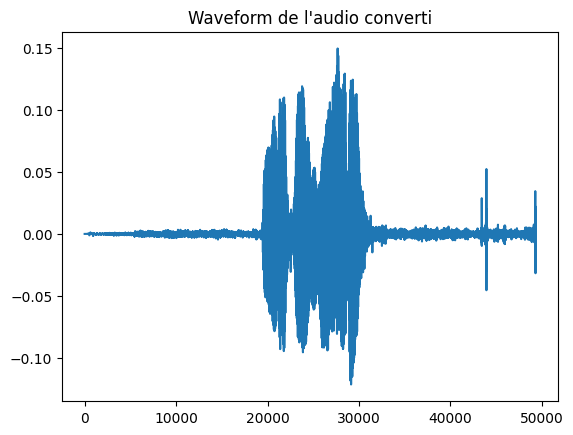

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

speech_array, sampling_rate = mp3_to_wav_array(mp3_file)
print(f"Sampling rate: {sampling_rate}")
print(f"Signal shape: {speech_array.shape}")
print(f"Signal min/max: {np.min(speech_array.numpy())} / {np.max(speech_array.numpy())}")

# Affiche la forme d'onde du signal (premier canal)
plt.plot(speech_array[0].numpy())
plt.title("Waveform de l'audio converti")
plt.show()
